## Tensorflow Tutorial 3: Build First Convolutional Neurel Network (CNN)

這一章我們終於要討論到影像辨識的重頭戲啦！通常，處理影像類別我們會用Convolutional Neurel Network，聽起來很難很厲害，不過只要了解背後概念你就知道為什麼要這麼做了，讓我們看下去。

本單元程式碼可於[Github](https://github.com/GitYCC/Tensorflow_Tutorial/blob/master/code/03_CNN_classification_on_MNIST.py)下載。

### 影像有什麼特性

來想一下，影像具備了什麼特性？

(1) 局域性：通常物件只在一個局域的範圍裡有效，而與太遠的距離無關，譬如我要找一張圖的鳥嘴，鳥嘴的呈現在一張圖當中只會出現在一個小範圍內，所以其實只需要評估這小範圍就可以判斷這是不是鳥嘴了。

(2) 平移性：通常一張圖任意平移並不影響它的意義，一隻鳥不管是放在圖片的左上角還是右下角，牠都是一隻鳥。

(3) 縮放性：通常一張圖我把它等比例的放大縮小是不影響它的意義的。

![影像特性](https://raw.githubusercontent.com/GitYCC/Tensorflow_Tutorial/master/img/TensorflowTutorial.004.jpeg)

### DNN用在影像上的侷限

我們剛剛看過了影像具有的三種特性：「局域性」、「平移性」和「縮放性」，那我們就拿這三種特性來檢驗上一回的DNN Classification。

DNN有「局域性」嗎？沒有，因為我們把圖片攤平處理，原本應該是相鄰的關係就被打壞了，事實上DNN的結構會造成每個Input都會同時影響下一層的「每個」神經元，所以相不相鄰根本沒關係，因為每個Pixels的影響是全域的。

DNN有「平移性」嗎？沒有，沒有局域性就沒有平移性。

DNN有「縮放性」嗎？我們沒有一層試著去縮放，而且圖片已經被攤平了，難以做到縮放的效果。

所以其實使用DNN並不能好好的詮釋影像。

### Convolutional Neurel Network (CNN)

我們需要引入新的架構來處理影像，讓它可以擁有以上三種特性，Convolutional Neurel Network (CNN)此時就登場了，CNN有兩大新要素：Convolution Layer和Pooling Layer，Convolution Layer為我們的Model添加了局域性和平移性，而Pooling Layer則讓Model擁有縮放的特性。

![Convolution Layer和Pooling Layer](https://raw.githubusercontent.com/GitYCC/Tensorflow_Tutorial/master/img/TensorflowTutorial.005.jpeg)

Convolution Layer是由Filters所構成的，Filters可以想像是一張小圖，以上面的例子，Filter是一個鳥嘴的小圖，這張小圖要怎麼去過濾原圖呢？答案是使用Convolution(卷積)，把小圖疊到大圖的任意位置，接下來將大圖小圖對到的相應元素相乘起來再加總一起，然後在另外一張表格中填入這個加總值，接下來移動Filter，重複的動作再做一次，如此循環並將值陸續填入表格中，這表格最後就會像是另外一張圖一樣，而這張圖可以繼續串另外的Neurel Network，這就是Convolution Layer的計算方法。

舉個例子，假設我今天有矩陣A：

[[1, 2, 3, 4],<br/>
 [4, 5, 6, 7],<br/>
 [7, 8, 9,10],<br/>
 [1, 3, 5, 7]]

然後再有一個Filter：

[[1, 0, 0],<br/>
 [0, 1, 0],<br/>
 [0, 0, 0]]

使用Filter對A做Convolution得到B為：

[[6, 8 ],<br/>
 [12,14]]
 
原本4x4的矩陣做了Convolution後變成了2x2的矩陣，原因在於邊界限制了Filter的移動，那如果我想要讓Convolution玩的矩陣維持在4x4，怎麼做？我們可以在邊緣的地方鋪上0就可以達到這樣的效果，來試試看，先將矩陣A擴張成矩陣C：

[[0, 0, 0, 0, 0, 0],<br/>
 [0, 1, 2, 3, 4, 0],<br/>
 [0, 4, 5, 6, 7, 0],<br/>
 [0, 7, 8, 9,10, 0],<br/>
 [0, 1, 3, 5, 7, 0],<br/>
 [0, 0, 0, 0, 0, 0]]
 
再使用Filter對C做Convolution會得到D為：

[[1, 2, 3, 4],<br/>
 [4, 6, 8,10],<br/>
 [7,12,14,16],<br/>
 [1,10,13,16]]
 
而此時D就是一個4x4的矩陣。

Convolution的過程造成怎麼樣的效果呢？當Filter是一個鳥嘴的小圖，一旦遇到與鳥嘴相似的局部，此時加總的值會是一個大的值，如果是一個和鳥嘴無關的局部此時的值會是一個小的值，所以這個Filter具有將特定特徵篩選出來的能力，符合特徵分數高不符合則分數低，因此局部的特徵變得是有意義的，此時我的Model就具有局域性，而且藉由Filter的平移掃視，這個特徵就具有可平移的特性。

Convolution Layer不同於Fully-connected Layer有兩點，第一，每個Pixels間有相對的距離關係，擁有上下左右的關係才有辦法構成一張圖，第二，除了有距離上的關係以外，它還能在有限範圍內抓出一種特徵模式，所以我們將可以使用影像的語言來做特徵轉換和抓取特徵。

實際情況下，Filter上的Weights是會自行調整的，Model Fitting的時候，Model會根據數據自行訓練出Filter，也就是說機器可以自行學習出圖片的特徵。通常這樣的Filters會有好幾個，讓機器可以有更多維度可以學習。

接下來來看Pooling Layer如何讓Model擁有檢視縮放的特性？

先來看在影像上如何做到放大縮小，以Pixels的觀點來看，最簡單的放大方法是，在每個既有的Pixels附近增加一些與它們相似的新Pixel，這樣做就像是將原本的小圖直接拉成大圖，畫質雖然很差，不過這是最簡單的放大方法。那麼縮小就相反操作，把一群附近的Pixels濃縮成一個Pixel當作代表，就可以達到縮小圖片的效果。

所以回到Pooling Layer的討論，Pooling做的事情就是在縮小圖片，例如我使用2x2來做Pooling，它會在原圖上以2x2來掃描，所以會有四個元素被檢視，然後從這四個值當中產生一個代表值，把原本2x2的Pixels減少成這個1x1的代表值，如果是Max Pooling就是從四個中選最大的那個，如果是Average Pooling則是平均四個值得到平均值，通常如果是2x2的Pooling我們會以每2格一跳的方式掃視，如果是3x3則會以每3格一跳，以此類推。

### Convolution Layer

來看一下Tensorflow如何實作Convolution Layer。

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [2]:
with tf.Session() as sess:
    img =tf.constant([[[[1],[2],[0],[0],[0]],
                       [[3],[0],[0],[1],[2]],
                       [[0],[0],[0],[3],[0]],
                       [[1],[0],[0],[1],[0]],
                       [[0],[0],[0],[0],[0]]]],tf.float32)
    # shape of img: [batch, in_height, in_width, in_channels]
    
    filter_ = tf.constant([[[[1]],[[2]]],
                           [[[3]],[[0]]]],tf.float32)
    # shape of filter: [filter_height, filter_width, in_channels, out_channels]
    
    conv_strides = (1,1)
    padding_method = 'VALID'
    
    conv = tf.nn.conv2d(img, filter_, 
                        strides=[1,conv_strides[0],conv_strides[1],1], 
                        padding=padding_method)
    print("Shape of conv:")
    print(conv.eval().shape)
    print("Conv:")
    print(conv.eval())

Shape of conv:
(1, 4, 4, 1)
Conv:
[[[[ 14.]
   [  2.]
   [  0.]
   [  3.]]

  [[  3.]
   [  0.]
   [  2.]
   [ 14.]]

  [[  3.]
   [  0.]
   [  6.]
   [  6.]]

  [[  1.]
   [  0.]
   [  2.]
   [  1.]]]]


首先一開始是圖片`img`的部分，Rank為4，每個維度分別為`[batch, in_height, in_width, in_channels]`，in_channels的部分一般是RGB，這邊我採用和MNIST相同的灰階表示，所以in_channels只有1個維度。

`filter_`的部分Rank為4，每個維度分別為`[filter_height, filter_width, in_channels, out_channels]`，當如果我想要使用多個filters的時候，我的out_channels就不只1而已，如果有RGB的話，in_channels則會是3。

接下來來看一下`tf.nn.conv2d`裡頭的參數`strides`，這可能會讓人感到困惑，它的設定值是`[1,conv_strides[0],conv_strides[1],1]`，我特別把第二、三項額外用`conv_strides`來表示，因為這兩個值才是真正代表在圖片上平移每步的距離，那第一項和最後一項的1代表什麼意義呢？是這樣的，Tensorflow是站在維度的角度看平移這件事情，這四個維度分別表示`[batch, in_height, in_width, in_channels]`的移動量，所以一般情況下只有`in_height`和`in_width`需要指定平移的距離。

最後一個參數就是`padding`，有兩種可以選擇，分別為`VALID`和`SAME`，`VALID`指的就是沒有額外鋪上0的邊界的情形，`SAME`則是額外鋪上0的邊界，並且使得輸出的維度和輸入一樣。

### Pooling Layer

接下來來看Tensorflow如何實作Pooling Layer。

In [3]:
with tf.Session() as sess:
    img =tf.constant([[[[1],[2],[0],[0]],
                       [[3],[0],[0],[1]],
                       [[0],[0],[0],[3]],
                       [[1],[0],[0],[1]]]],tf.float32)
    # shape of img: [batch, in_height, in_width, in_channels]
    
    pooling = tf.nn.max_pool(img,
                    ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    print("Shape of pooling:")
    print(pooling.eval().shape)
    print("Pooling:")
    print(pooling.eval())

Shape of pooling:
(1, 2, 2, 1)
Pooling:
[[[[ 3.]
   [ 1.]]

  [[ 1.]
   [ 3.]]]]


`tf.nn.max_pool`的參數中`ksize`代表kernel size，也就是要Pooling的大小，一樣依照Input layer的Rank去配置，還有`strides`決定平移的方法。

### 最簡單的CNN架構：LeNet5

![LeNet5](https://raw.githubusercontent.com/GitYCC/Tensorflow_Tutorial/master/img/TensorflowTutorial.006.jpeg)

接下來我們就真正的來實作一下CNN網路，和之前兩個單元一樣，我們拿MNIST的分類問題來當作題目。

本單元介紹的是最簡單的CNN Classification的方法—LeNet5，流程如上圖所示。

(1) conv1+relu+pooling2：一開始使用Convolution抓取圖片中的特徵，並且加入Activation Function使得Model具有非線性因子，通常在這種非常深的網路，我們會採用Relu，它的好處是不會出現「梯度消失」(Vanishing Gradient)的問題，如果你使用像是tanh或sigmoid這類在飽和區梯度接近0的函數，則就很有可能在深網路的情形下，造成一開始的幾個Layers梯度太小的問題，也就是前面幾層我們無法訓練到，而Relu在Turn-on的情況下是線性的，不會有飽和的問題，也就不會出現「梯度消失」。做完Convolution後，我們已經對於這個圖片有一點認識了，所以減少一些Pixels來減少一些計算量，所以加入Pooling Layer，注意喔！Pooling Layer結束之後，不需要再做一次Activation，因為Pooling只是用來平均前面的結果而已。

(2) conv3+relu+pooling4：做第二次的圖片特徵抽取。

(3) fatten5：將抽取完的特徵完全打平，為了接下來的Fully-connected Network做準備。

(4) fc6+fc7+fc8+softmax：這個部分就和之前DNN Classification做的事情一樣，全盤考慮每一個擷取來的特徵，並且非線性的轉換成最後可以分為相應的10種類別。

接下來我們看一下程式碼要怎麼寫？

In [5]:
class CNNLogisticClassification(object):
    def __init__(self,shape_picture,n_labels,
                 learning_rate=0.5,dropout_ratio=0.5,alpha=0.0):
        self.shape_picture = shape_picture
        self.n_labels = n_labels
        
        self.weights = None
        self.biases = None
        
        self.graph = tf.Graph() # initialize new grap
        self.build(learning_rate,dropout_ratio,alpha) # building graph
        self.sess = tf.Session(graph=self.graph) # create session by the graph 
        
    def build(self,learning_rate,dropout_ratio,alpha):
        with self.graph.as_default():
            ### Input
            self.train_pictures = tf.placeholder(tf.float32, 
                                                 shape=[None]+self.shape_picture)
            self.train_labels   = tf.placeholder(tf.int32, 
                                                 shape=(None,self.n_labels))

            ### Optimalization
            # build neurel network structure and get their predictions and loss
            self.y_,self.original_loss = self.structure(pictures=self.train_pictures,
                                                        labels=self.train_labels,
                                                        dropout_ratio=dropout_ratio,
                                                        train=True, )
            # regularization loss
            self.regularization = tf.reduce_sum(
                    [tf.nn.l2_loss(w) for w in self.weights.values()]) \
                    / tf.reduce_sum(
                     [tf.size(w,out_type=tf.float32) for w in self.weights.values()])
                
            # total loss
            self.loss = self.original_loss + alpha * self.regularization
            
            # define training operation
            optimizer = tf.train.GradientDescentOptimizer(learning_rate)
            self.train_op = optimizer.minimize(self.loss)
            
            ### Prediction
            self.new_pictures = tf.placeholder(tf.float32, 
                                               shape=[None]+self.shape_picture)
            self.new_labels   = tf.placeholder(tf.int32, 
                                               shape=(None,self.n_labels))
            self.new_y_,self.new_original_loss = self.structure(pictures=self.new_pictures,
                                                       labels=self.new_labels,)
            self.new_loss = self.new_original_loss + alpha * self.regularization
            
            ### Initialization
            self.init_op = tf.global_variables_initializer()
    
    def structure(self,pictures,labels,dropout_ratio=None,train=False):
        
        ### Variable
        ## LeNet5 Architecture(http://yann.lecun.com/exdb/lenet/) 
        # input:(batch,28,28,1) => conv1[5x5,6] => (batch,24,24,6)
        # pool2 => (batch,12,12,6) => conv2[5x5,16] => (batch,8,8,16)
        # pool4 => fatten5 => (batch,4x4x16) => fc6 => (batch,120)
        # (batch,120) => fc7 => (batch,84)
        # (batch,84) => fc8 => (batch,10) => softmax
        
        if (not self.weights) and (not self.biases):
            
            self.weights = {
                'conv1': tf.Variable(tf.truncated_normal(shape=(5,5,1,6),
                                                         stddev=0.1)), 
                'conv3': tf.Variable(tf.truncated_normal(shape=(5,5,6,16),
                                                         stddev=0.1)),
                'fc6':   tf.Variable(tf.truncated_normal(shape=(4*4*16,120),
                                                         stddev=0.1)),
                'fc7':   tf.Variable(tf.truncated_normal(shape=(120,84),
                                                         stddev=0.1)),    
                'fc8':   tf.Variable(tf.truncated_normal(shape=(84,self.n_labels),
                                                         stddev=0.1)),                   
            }
            self.biases  = {
                'conv1': tf.Variable(tf.zeros( shape=(6) )),
                'conv3': tf.Variable(tf.zeros( shape=(16) )),
                'fc6':   tf.Variable(tf.zeros( shape=(120) )),
                'fc7':   tf.Variable(tf.zeros( shape=(84) )),
                'fc8':   tf.Variable(tf.zeros( shape=(self.n_labels) )),
            } 
        
        ### Structure
        conv1 = self.getConv2DLayer(pictures,
                                    self.weights['conv1'],self.biases['conv1'],
                                    activation=tf.nn.relu)
        pool2 = tf.nn.max_pool(conv1,
                               ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
        conv3 = self.getConv2DLayer(pool2,
                                    self.weights['conv3'],self.biases['conv3'],
                                    activation=tf.nn.relu)
        pool4 = tf.nn.max_pool(conv3,
                               ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
        fatten5 = self.getFlattenLayer(pool4)
        
        if train: fatten5 = tf.nn.dropout(fatten5,keep_prob=1-dropout_ratio[0])
        
        fc6 = self.getDenseLayer(fatten5,
                                 self.weights['fc6'],self.biases['fc6'],
                                 activation=tf.nn.relu)
        
        if train: fc6 = tf.nn.dropout(fc6,keep_prob=1-dropout_ratio[1])
        
        fc7 = self.getDenseLayer(fc6,
                                 self.weights['fc7'],self.biases['fc7'],
                                 activation=tf.nn.relu)
            
        logits = self.getDenseLayer(fc7,self.weights['fc8'],self.biases['fc8'])
        
        y_ = tf.nn.softmax(logits)
        loss = tf.reduce_mean(
                 tf.nn.softmax_cross_entropy_with_logits(labels=labels,
                                                         logits=logits))

        return (y_,loss)
    
    def getDenseLayer(self,input_layer,weight,bias,activation=None):
        x = tf.add(tf.matmul(input_layer,weight),bias)
        if activation:
            x = activation(x)
        return x
    
    def getConv2DLayer(self,input_layer,
                       weight,bias,
                       strides=(1,1),padding='VALID',activation=None):
        x = tf.add(
              tf.nn.conv2d(input_layer,
                           weight,
                           [1,strides[0],strides[1],1],
                           padding=padding),bias)
        if activation:
            x = activation(x)
        return x

    def getFlattenLayer(self,input_layer):
        shape = input_layer.get_shape().as_list()
        n = 1
        for s in shape[1:]:
            n *= s
        x = tf.reshape(input_layer,[-1,n])
        return x
    
    def fit(self,X,y,epochs=10,
            validation_data=None,test_data=None,batch_size=None):
        X = self._check_array(X)
        y = self._check_array(y)
        
        N = X.shape[0]
        random.seed(9000)
        if not batch_size: batch_size=N
        
        self.sess.run(self.init_op)
        for epoch in range(epochs):
            print("Epoch %2d/%2d: "%(epoch+1,epochs))
            
            # mini-batch gradient descent
            index = [i for i in range(N)]
            random.shuffle(index)
            while len(index)>0:
                index_size = len(index)
                batch_index=[index.pop() for _ in range(min(batch_size,index_size))]    
            
                feed_dict = {
                    self.train_pictures: X[batch_index,:], 
                    self.train_labels: y[batch_index], 
                }
                _, loss = self.sess.run([self.train_op, self.loss],
                                        feed_dict=feed_dict)
                
                print("[%d/%d] loss = %.4f     "%(N-len(index),N,loss),end='\r')

            
            # evaluate at the end of this epoch
            y_ = self.predict(X)
            train_loss = self.evaluate(X,y)
            train_acc = self.accuracy(y_,y)
            msg = "[%d/%d] loss = %8.4f, acc = %3.2f%%"%(N,N,train_loss,train_acc*100)
            
            if validation_data:
                val_loss = self.evaluate(validation_data[0],validation_data[1])
                val_acc = self.accuracy(self.predict(validation_data[0]),validation_data[1])
                msg+=", val_loss = %8.4f, val_acc = %3.2f%%"%( val_loss, val_acc*100 )
            
            print(msg)
            
            
        if test_data:
            test_acc = self.accuracy(self.predict(test_data[0]),test_data[1])
            print("test_acc = %3.2f%%" % (test_acc*100))
            
    def accuracy(self, predictions, labels):
        return (np.sum(np.argmax(predictions,1)==np.argmax(labels,1))/predictions.shape[0])
    
    def predict(self,X):
        X = self._check_array(X)
        return self.sess.run(self.new_y_, feed_dict={self.new_pictures: X})
    
    def evaluate(self,X,y):
        X = self._check_array(X)
        y = self._check_array(y)
        return self.sess.run(self.new_loss, feed_dict={self.new_pictures: X, 
                                                       self.new_labels: y})
    
    def _check_array(self,ndarray):
        ndarray = np.array(ndarray)
        if len(ndarray.shape)==1: 
            ndarray=np.reshape(ndarray,(1,ndarray.shape[0]))
        return ndarray
    

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train_data = mnist.train
valid_data = mnist.validation
test_data = mnist.test

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [8]:
model = CNNLogisticClassification(   shape_picture=[28,28,1],
                                     n_labels=10,
                                     learning_rate=0.07,
                                     dropout_ratio=[0.2,0.1],
                                     alpha=0.1,
                                 )

train_img = np.reshape(train_data.images,[-1,28,28,1])
valid_img = np.reshape(valid_data.images,[-1,28,28,1])
test_img  = np.reshape(test_data.images,[-1,28,28,1])

model.fit(X=train_img,
          y=train_data.labels,
          epochs=10,
          validation_data=(valid_img,valid_data.labels),
          test_data=(test_img,test_data.labels),
          batch_size = 32,
         )

Epoch  1/10: 
[55000/55000] loss =   0.0982, acc = 96.91%, val_loss =   0.0926, val_acc = 97.14%
Epoch  2/10: 
[55000/55000] loss =   0.0599, acc = 98.10%, val_loss =   0.0691, val_acc = 97.98%
Epoch  3/10: 
[55000/55000] loss =   0.0468, acc = 98.52%, val_loss =   0.0522, val_acc = 98.58%
Epoch  4/10: 
[55000/55000] loss =   0.0420, acc = 98.72%, val_loss =   0.0505, val_acc = 98.60%
Epoch  5/10: 
[55000/55000] loss =   0.0325, acc = 99.09%, val_loss =   0.0432, val_acc = 98.84%
Epoch  6/10: 
[55000/55000] loss =   0.0265, acc = 99.18%, val_loss =   0.0423, val_acc = 98.78%
Epoch  7/10: 
[55000/55000] loss =   0.0245, acc = 99.26%, val_loss =   0.0395, val_acc = 99.02%
Epoch  8/10: 
[55000/55000] loss =   0.0240, acc = 99.29%, val_loss =   0.0417, val_acc = 98.78%
Epoch  9/10: 
[55000/55000] loss =   0.0216, acc = 99.33%, val_loss =   0.0379, val_acc = 99.00%
Epoch 10/10: 
[55000/55000] loss =   0.0179, acc = 99.47%, val_loss =   0.0347, val_acc = 99.04%
test_acc = 99.15%


太棒了！我們的預測效果如果跟之前的結果比較，在Epoch=3已經達到98.5%了，在Epoch=10更是高達99%！

### 圖像化

有這麼好的成果，我們不妨就拉進去看，裡面每個Filters究竟是長什麼樣子的？

先來看第一層Convolution的Filters。

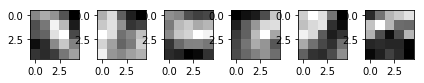

In [9]:
fig, axis = plt.subplots(1, 6, figsize=(7, 0.9))
for i in range(0,6):
    img = model.sess.run(model.weights['conv1'])[:,:,:,i]
    img = np.reshape(img,(5,5))
    axis[i].imshow(img, cmap='gray')
plt.show()

再來看第二層Convolution的Filters。

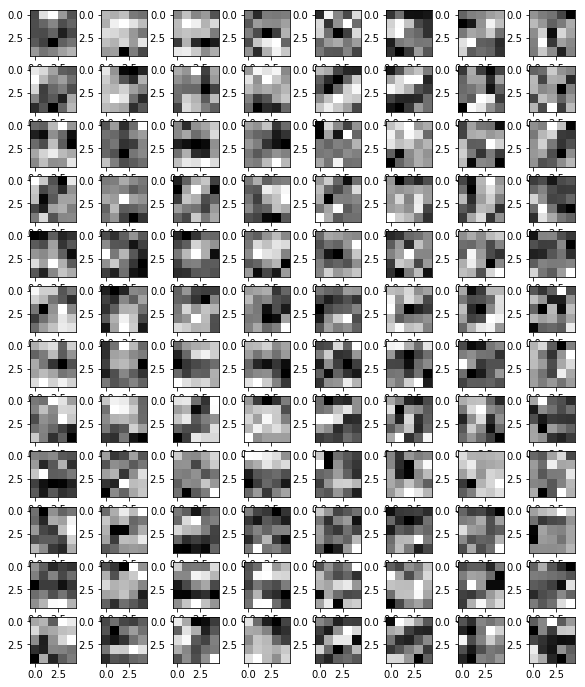

In [10]:
fig, axis = plt.subplots(12, 8, figsize=(10, 12))
for i in range(6):
    for j in range(16):
        img = model.sess.run(model.weights['conv3'])[:,:,i,j]
        img = np.reshape(img,(5,5))
        axis[i*2+j//8][j%8].imshow(img, cmap='gray')
plt.show()

單看這些Filters似乎很難看出什麼？

我們試著丟幾張圖進去做Convolution，看一下在Filters的拆解之下圖片會變怎樣？

以下圖片的第一行表示原圖片，第二行表示做完第一次Convolution後的結果，第三行表示做完第二次Convolution後的結果。

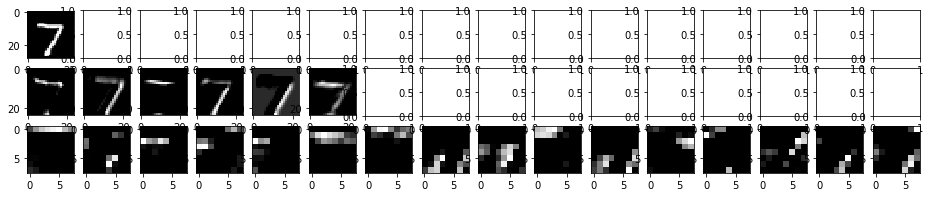

In [11]:
fig, axis = plt.subplots(3, 16, figsize=(16, 3))
picture = np.reshape(test_img[0,:,:,:],(1,28,28,1))

with model.sess.as_default():
    conv1 = model.getConv2DLayer(picture,
                         model.weights['conv1'],model.biases['conv1'],
                         activation=tf.nn.relu)
    pool2 = tf.nn.max_pool(conv1,
                         ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    conv3 = model.getConv2DLayer(pool2,
                         model.weights['conv3'],model.biases['conv3'],
                         activation=tf.nn.relu)
    eval_conv1 = conv1.eval()
    eval_conv3 = conv3.eval()

axis[0][0].imshow(np.reshape(picture,(28,28)), cmap='gray')
for i in range(6):
    img = eval_conv1[:,:,:,i]
    img = np.reshape(img,(24,24))
    axis[1][i].imshow(img, cmap='gray')
for i in range(16):
    img = eval_conv3[:,:,:,i]
    img = np.reshape(img,(8,8))
    axis[2][i].imshow(img, cmap='gray')
plt.show()

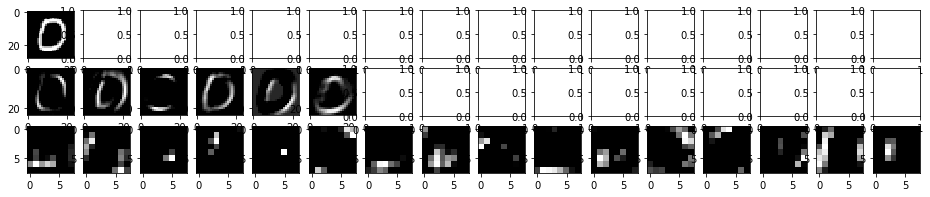

In [12]:
fig, axis = plt.subplots(3, 16, figsize=(16, 3))
picture = np.reshape(test_img[10,:,:,:],(1,28,28,1))

with model.sess.as_default():
    conv1 = model.getConv2DLayer(picture,
                         model.weights['conv1'],model.biases['conv1'],
                         activation=tf.nn.relu)
    pool2 = tf.nn.max_pool(conv1,
                         ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    conv3 = model.getConv2DLayer(pool2,
                         model.weights['conv3'],model.biases['conv3'],
                         activation=tf.nn.relu)
    eval_conv1 = conv1.eval()
    eval_conv3 = conv3.eval()

axis[0][0].imshow(np.reshape(picture,(28,28)), cmap='gray')
for i in range(6):
    img = eval_conv1[:,:,:,i]
    img = np.reshape(img,(24,24))
    axis[1][i].imshow(img, cmap='gray')
for i in range(16):
    img = eval_conv3[:,:,:,i]
    img = np.reshape(img,(8,8))
    axis[2][i].imshow(img, cmap='gray')
plt.show()

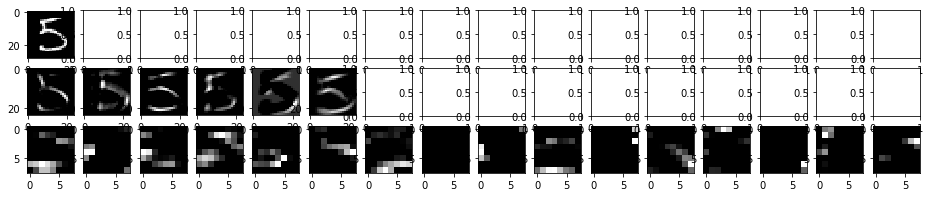

In [13]:
fig, axis = plt.subplots(3, 16, figsize=(16, 3))
picture = np.reshape(test_img[15,:,:,:],(1,28,28,1))

with model.sess.as_default():
    conv1 = model.getConv2DLayer(picture,
                         model.weights['conv1'],model.biases['conv1'],
                         activation=tf.nn.relu)
    pool2 = tf.nn.max_pool(conv1,
                         ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
    
    conv3 = model.getConv2DLayer(pool2,
                         model.weights['conv3'],model.biases['conv3'],
                         activation=tf.nn.relu)
    eval_conv1 = conv1.eval()
    eval_conv3 = conv3.eval()

axis[0][0].imshow(np.reshape(picture,(28,28)), cmap='gray')
for i in range(6):
    img = eval_conv1[:,:,:,i]
    img = np.reshape(img,(24,24))
    axis[1][i].imshow(img, cmap='gray')
for i in range(16):
    img = eval_conv3[:,:,:,i]
    img = np.reshape(img,(8,8))
    axis[2][i].imshow(img, cmap='gray')
plt.show()

有看出什麼規律嗎？哈哈。